In [1]:
import paddle
import numpy as np
import cv2
from PIL import Image
import zipfile
import os
import matplotlib.pyplot as plt

In [2]:
train_parameters={
    "input_size":[3,64,64],
    "class_dim":5,
    "src_path":'foods.zip',
    "target_path":'dataset',
    'train_list_path':'./train.txt',
    'eval_list_path':'./eval.txt',
    'readme_path':'./readme.json',
    'label_dict':{},
    'num_epochs':20,
    'train_batch_size':64,
    'learning_strategy':{
        'lr':0.001
    }

}

In [3]:
def unzip_data(src_path,target_path):
    if os.path.isdir(target_path):
        print('文件已解压')
    else:
        z=zipfile.ZipFile(src_path)
        z.extractall(path=target_path)
        z.close()

In [4]:
unzip_data(train_parameters['src_path'],train_parameters['target_path'])

In [5]:
def get_list(path,train_path,eval_path):
    path=os.path.join(path,'foods')
    kinds=os.listdir(path)

    train_list=[]
    eval_list=[]
    label=0
    cnt=0
    for kind in kinds:
        kind_path=os.path.join(path,kind)
        imgs=os.listdir(kind_path)
        for img in imgs:
            cnt+=1
            img_path=os.path.join(kind_path,img)
            if cnt%10==0:
                eval_list.append("{}\t{}\n".format(img_path,str(label)))
            else:
                train_list.append("{}\t{}\n".format(img_path,str(label)))
        label+=1
        train_parameters['label_dict'][str(label)]=kind
    
    with open(train_path,'w') as f:
        for line in train_list:
            f.write(line)

    with open(eval_path,'w') as f:
        for line in eval_list:
            f.write(line)



In [6]:
get_list(train_parameters['target_path'],train_parameters['train_list_path'],train_parameters['eval_list_path'])

In [7]:
class FoodDataset(paddle.io.Dataset):
    def __init__(self,path):
        super().__init__()
        
        self.data_list=[]
        with open(path,'r',encoding='utf-8') as f:
            for line in f.readlines():
                img_path,label=line.strip().split('\t')
                self.data_list.append((img_path,int(label)))
                
    def __getitem__(self,index):
        img_path,label=self.data_list[index]
        
        img=Image.open(img_path)
        if img.mode != 'RGB':
            img=img.convert('RGB')
        img=img.resize((64,64),Image.BILINEAR)
        img=np.array(img).astype('float32')
        img=img.transpose((2,0,1))/255.0

        return img,np.array([label],dtype='int64')

    def __len__(self):
        return len(self.data_list)

In [8]:
train_dataset=FoodDataset(train_parameters['train_list_path'])
eval_dataset=FoodDataset(train_parameters['eval_list_path'])
train_loader=paddle.io.DataLoader(train_dataset,batch_size=train_parameters['train_batch_size'],shuffle=True)
eval_loader=paddle.io.DataLoader(eval_dataset,batch_size=train_parameters['train_batch_size'],shuffle=False)

In [9]:
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv0=paddle.nn.Conv2D(in_channels=3,out_channels=64,kernel_size=3,padding=0,stride=1)
        self.pool0=paddle.nn.MaxPool2D(kernel_size=2,stride=2)
        self.conv1=paddle.nn.Conv2D(in_channels=64,out_channels=128,kernel_size=4,padding=0,stride=1)
        self.pool1=paddle.nn.MaxPool2D(kernel_size=2,stride=2)
        self.conv2=paddle.nn.Conv2D(in_channels=128,out_channels=128,kernel_size=5,padding=0)
        self.pool2=paddle.nn.MaxPool2D(kernel_size=2,stride=2)
        self.fc1=paddle.nn.Linear(in_features=128*5*5,out_features=5)

    def forward(self,input):
        x=self.conv0(input)
        x=self.pool0(x)
        x=self.conv1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.pool2(x)
        x=paddle.fluid.layers.reshape(x,shape=[-1,128*5*5])
        y=self.fc1(x)
        return y
           

In [10]:
model=MyCNN()
model.train()
cross_entropy=paddle.nn.CrossEntropyLoss()
opt=paddle.optimizer.SGD(learning_rate=train_parameters['learning_strategy']['lr'],parameters=model.parameters())

Batch=0
losses=[]
accs=[]
batchs=[]
for pass_num in range(train_parameters['num_epochs']):
    
    for batch_id,data in enumerate(train_loader()):
        x=data[0]
        y=data[1]
        pred=model(x)
        # print(x)
        # print(y)
        loss=cross_entropy(pred,y)
        # print(loss)
        acc=paddle.metric.accuracy(pred,y.reshape([-1,1]))

        if batch_id!=0 and batch_id%10==0:
            Batch+=10
            batchs.append(Batch)
            losses.append(loss.numpy()[0])
            accs.append(acc.numpy()[0])
            print("epoch:{},step:{},loss:{},acc:{}".format(pass_num,batch_id,loss.numpy()[0],acc.numpy()[0]))
        
        loss.backward()
        opt.step()
        opt.clear_grad()

# paddle.save(model.state_dict(),'MyCNN')

epoch:0,step:10,loss:1.7988860607147217,acc:0.21875
epoch:0,step:20,loss:1.697974443435669,acc:0.265625
epoch:0,step:30,loss:1.829293966293335,acc:0.1875
epoch:0,step:40,loss:1.7868056297302246,acc:0.328125
epoch:0,step:50,loss:1.7599623203277588,acc:0.1875
epoch:0,step:60,loss:1.696953535079956,acc:0.328125
epoch:0,step:70,loss:1.3444684743881226,acc:0.30000001192092896
epoch:1,step:10,loss:1.490311622619629,acc:0.3125
epoch:1,step:20,loss:1.3505992889404297,acc:0.40625
epoch:1,step:30,loss:1.5401219129562378,acc:0.359375
epoch:1,step:40,loss:1.4661024808883667,acc:0.359375
epoch:1,step:50,loss:1.4064040184020996,acc:0.375
epoch:1,step:60,loss:1.5312039852142334,acc:0.359375
epoch:1,step:70,loss:1.2378193140029907,acc:0.5
epoch:2,step:10,loss:1.3815884590148926,acc:0.40625
epoch:2,step:20,loss:1.3419042825698853,acc:0.46875
epoch:2,step:30,loss:1.3457156419754028,acc:0.40625
epoch:2,step:40,loss:1.3570177555084229,acc:0.359375
epoch:2,step:50,loss:1.4156925678253174,acc:0.375
epoch:2,

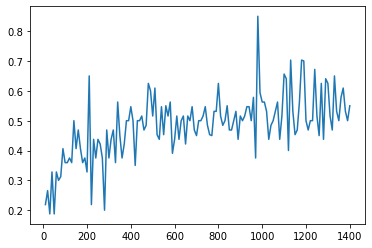

In [11]:
plt.plot(batchs,accs)

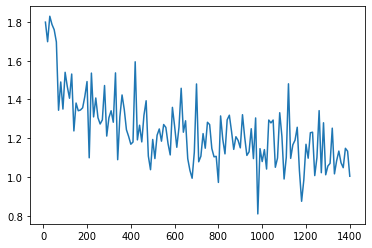

In [12]:
plt.plot(batchs,losses)

In [14]:
paddle.save(model.state_dict(),'MyCNN')

In [15]:
para_state_dict=paddle.load("MyCNN")
model=MyCNN()
model.set_state_dict(para_state_dict)
model.eval()

accs=[]
for batch_id,data in enumerate(eval_loader()):
    x=data[0]
    y=data[1]
    pred=model(x)
    acc=paddle.metric.accuracy(pred,y)
    accs.append(acc.numpy()[0])

print(np.mean(accs))

0.4921875
